## Classification

### Feature Selection

**Initial Discard Variables**
- Variable `LoanAmount` will **not** be used due to data leakage with the addition of the Stage 2 Loan Amount Regression Model
- Variable `Gender` will **not** be used due to EDA findings
- Variable `Self_Employed` will **not** be used due to EDA findings

**Initial Selected Features**
`Married`, `Dependents`, `Education`, `ApplicantIncome`, `CoapplicationIncome`, `Loan_Amount_Term`, `Credit_History`, `Property_Area`

**After Training Selected Features**
`Married`, `Dependents`, `ApplicantIncome`, `CoapplicationIncome`, `Loan_Amount_Term`, `Credit_History`, `Property_Area`, `TotalIncome`, `IncomePerDependent`

In [1]:
# Install Dependencies

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, learning_curve
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import randint, loguniform, uniform
from xgboost import XGBClassifier

In [158]:
df = pd.read_csv(os.path.join("data", "train_u6lujuX_CVtuZ9i.csv"))
test_df = pd.read_csv(os.path.join("data", "test_Y3wMUE5_7gLdaTN.csv"))
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [336]:
# Feature Selection
features = ['Married', 'Dependents', 'Education', 'ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']
target = 'Loan_Status'

### Pre-processing

In [349]:
X = df[features]
y = df[target]

X_test = df[features]
y_test = df[target]
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term', 'TotalIncome', 'IncomePerPerson']
categorical_features = ['Married', 'Dependents', 'Credit_History', 'Property_Area']

In [356]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['Dependents'] = X['Dependents'].replace('3+', 3).astype(float)
        X['TotalIncome'] = X['ApplicantIncome'] + X['CoapplicantIncome']
        X['IncomePerPerson'] = round(X['TotalIncome'] / (1 + (X['CoapplicantIncome'] > 0).astype(int) + X['Dependents']), 1)
        return X

In [350]:
y = y.map({'Y': 1, 'N': 0})
y_test = y_test.map({'Y': 1, 'N': 0})

In [ ]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log1p, validate=False)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

lr_model = Pipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight='balanced', max_iter=2000))
])

rf_model = Pipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        class_weight='balanced',
        max_depth=5,
        min_samples_split=15,
        min_samples_leaf=5,
        max_features='sqrt',
        n_estimators=200,
        random_state=37,
        ))
])

# max_depth = 5, 23
# min_samples_split = 5, 9
# min_samples_leaf = 2, 1
# n_estimators = 100, 214

xgb_model = Pipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        n_estimators=175,
        max_depth=6,
        learning_rate=0.15,
        subsample=0.67,
        colsample_bytree=0.61,
        reg_alpha=3,
        reg_lambda=2,
        eval_metric='auc',
        random_state=37,
        scale_pos_weight=(len(y) / sum(y))
    ))
])

# n_estimators = 500, 175
# max_depth = 4, 6
# learning_rate = 0.01, 0.15
# subsample = 0.7, 0.67
# colsample_bytree = 0.7, 0.61
# reg_lambda = 0, 2
# reg_alpha = 1, 3

svc_model = Pipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('model', SVC(
        kernel='rbf',
        C=0.04,
        gamma='scale',
        probability=True,
        class_weight='balanced',
        random_state=37
    ))
])

# kernel = 'rbf'
# C = 1.0, 0.04
# gamma = scale

mlp_model = Pipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('model', MLPClassifier(
        hidden_layer_sizes=(50, 25),
        activation='tanh',
        alpha=0.0027,
        learning_rate_init=0.0015,
        solver='adam',
        max_iter=1000,
        random_state=37
    ))
])

# hidden_layer_sizes = (64, 32), (50, 25)
# activation = relu, tanh
# alpha = 0.0001, 0.0027
# learning_rate_init = 0.001, 0.0015

knn_model = Pipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier(n_neighbors=5))
])

### Training

In [399]:
svc_model.fit(X, y)

y_predict = svc_model.predict(X_test)
y_probability = svc_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_predict))
print("ROC-AUC:", roc_auc_score(y_test, y_probability))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_predict, normalize='true'))

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.51      0.61       192
           1       0.81      0.93      0.86       422

    accuracy                           0.80       614
   macro avg       0.79      0.72      0.74       614
weighted avg       0.80      0.80      0.79       614

ROC-AUC: 0.7993804304897314
Confusion Matrix:
 [[0.50520833 0.49479167]
 [0.06635071 0.93364929]]


In [400]:
cv_scores = cross_val_score(svc_model, X, y, cv=5, scoring='roc_auc')
print("Cross-Validated AUC Scores:\n", cv_scores)
print("Mean CV AUC: ", cv_scores.mean())

Cross-Validated AUC Scores:
 [0.7879257  0.73653251 0.80311355 0.80799756 0.75281955]
Mean CV AUC:  0.7776777728635313


In [241]:
param_dist_lr = {
    'model__C': loguniform(0.001, 1000),
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs', 'liblinear']
}
rs_lr = RandomizedSearchCV(
    estimator=lr_model,
    param_distributions=param_dist_lr,
    n_iter=1000,
    cv=3,
    scoring='roc_auc',
    random_state=37,
    n_jobs=-1,
    verbose=1
)
rs_lr.fit(X, y)

print("\nBest params from Randomized Search:", rs_lr.best_params_)
print(f"Best ROC-AUC from Randomized Search: {rs_lr.best_score_:.4f}")

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits

Best params from Randomized Search: {'model__C': np.float64(6.167469100644247), 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best ROC-AUC from Randomized Search: 0.7521


In [166]:
param_dist_rf = {
    'model__n_estimators': randint(100, 1000),
    'model__max_depth': randint(5, 50),
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 10),
    'model__max_features': ['sqrt', 'log2']
}

rs_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_rf,
    n_iter=200,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rs_rf.fit(X, y)

print("\nBest params from Randomized Search:", rs_rf.best_params_)
print(f"Best ROC-AUC from Randomized Search: {rs_rf.best_score_:.4f}")

Fitting 3 folds for each of 200 candidates, totalling 600 fits

Best params from Randomized Search: {'model__max_depth': 34, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 6, 'model__n_estimators': 417}
Best ROC-AUC from Randomized Search: 0.7658


In [222]:
param_dist_xgb = {
    'model__n_estimators': randint(100, 1000),
    'model__max_depth': randint(2, 10),
    'model__learning_rate': uniform(0.01, 0.19),
    'model__subsample': uniform(0.6, 0.2),
    'model__colsample_bytree': uniform(0.6, 0.2),
    'model__reg_lambda': uniform(0, 4),
    'model__reg_alpha': uniform(0, 4),
}

rs_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=1000,
    cv=3,
    scoring='roc_auc',
    random_state=37,
    n_jobs=-1,
    verbose=1
)

rs_xgb.fit(X, y)

print("Best parameters:", rs_xgb.best_params_)
print("Best ROC-AUC:", rs_xgb.best_score_)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
Best parameters: {'model__colsample_bytree': np.float64(0.614693808211428), 'model__learning_rate': np.float64(0.15286713378729655), 'model__max_depth': 6, 'model__n_estimators': 175, 'model__reg_alpha': np.float64(3.032209123228632), 'model__reg_lambda': np.float64(2.0817342859864367), 'model__subsample': np.float64(0.6682896500783048)}
Best ROC-AUC: 0.7710298991050321


In [397]:
para_dist_svc = {
    'model__C': uniform(0.01, 10),
    'model__gamma': ['scale', 'auto'],
    'model__kernel': ['rbf', 'poly'],
    'model__degree': randint(2, 5)
}

rs_svc = RandomizedSearchCV(
    estimator=svc_model,
    param_distributions=para_dist_svc,
    n_iter=1000,
    cv=5,
    scoring='roc_auc',
    random_state=39,
    n_jobs=-1,
    verbose=1
)

rs_svc.fit(X, y)

print("Best parameters:", rs_svc.best_params_)
print("Best ROC-AUC:", rs_svc.best_score_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best parameters: {'model__C': np.float64(0.11513016362419635), 'model__degree': 4, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Best ROC-AUC: 0.7778016118728193


In [255]:
param_dist_mlp = {
    'model__hidden_layer_sizes': [(64, 32), (128, 64), (100, 50), (50, 25)],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': uniform(0.0001, 0.01),
    'model__learning_rate_init': uniform(0.0001, 0.01),
}

rs_mlp = RandomizedSearchCV(
    estimator=mlp_model,
    param_distributions=param_dist_mlp,
    n_iter=50,
    cv=3,
    scoring='roc_auc',
    random_state=37,
    n_jobs=-1,
    verbose=1
)

rs_mlp.fit(X, y)

print("Best parameters:", rs_mlp.best_params_)
print("Best ROC-AUC:", rs_mlp.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters: {'model__activation': 'tanh', 'model__alpha': np.float64(0.0027477760317622633), 'model__hidden_layer_sizes': (50, 25), 'model__learning_rate_init': np.float64(0.001474493749586545)}
Best ROC-AUC: 0.7764894144714622


### Visualisations

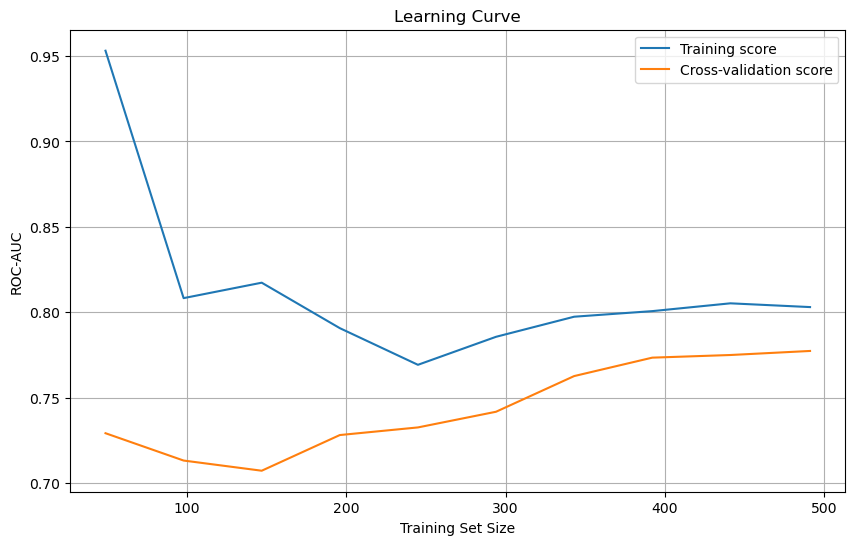

In [401]:
train_sizes, train_scores, val_scores = learning_curve( # type: ignore
    svc_model, X, y, cv=5, scoring='roc_auc', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, val_scores_mean, label='Cross-validation score')
plt.xlabel('Training Set Size')
plt.ylabel('ROC-AUC')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

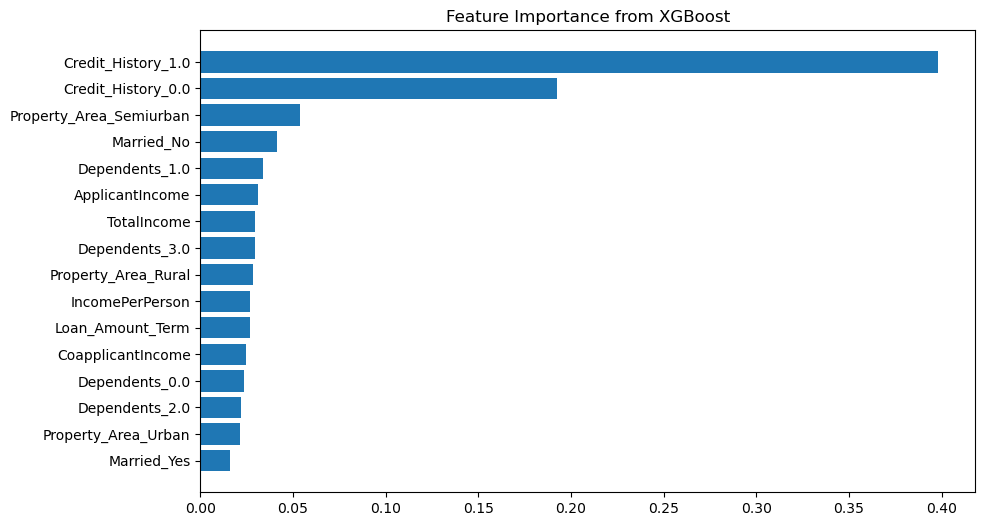

In [393]:
importances = xgb_model.named_steps['model'].feature_importances_

num_features = preprocessor.transformers_[0][2]

cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_cols = preprocessor.transformers_[1][2]
cat_features = cat_encoder.get_feature_names_out(cat_cols)

feature_names = list(num_features) + list(cat_features)

feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importance from XGBoost')
plt.show()